# PV ABM ML model

Tutorial from: https://youtu.be/0Lt9w-BxKFQ

Data from kaggle: https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009/data

In [154]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score, explained_variance_score, 
                             max_error, median_absolute_error)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from copy import deepcopy
%matplotlib inline
import operator
from IPython.display import display, clear_output

# Prep data


<ul>
<li>We obviously use supervised machine learning because we have labeled data (from the ABM).</li>
<li>We also use a regressor because our main input to look at is the % of PV waste diverted from landfill.</li>
<li>Following Vadhati et al. and common machine learning knowledge we use 4 different models: random forest, KNN,
SVM and neural network.</li>
</ul>

In [155]:
list_csv_file = []
number_files = 1
for i in range(number_files):
    list_csv_file.append("DataML_%s.csv" % i)
list_dataframe = []
for filename in list_csv_file:
    list_dataframe.append(pd.read_csv(filename))
pv_abm = pd.concat(list_dataframe)
pv_abm = pv_abm.drop(['seed', 'Unnamed: 0'], axis=1)
pv_abm_2 = deepcopy(pv_abm).groupby(['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5'], as_index=False).mean()
pv_abm.to_csv('pv_abm.csv')
pv_abm_2.to_csv('pv_abm_2.csv')
pv_abm = pd.read_csv("pv_abm.csv")
#X = pv_abm.drop(['Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6'], axis=1)
#y_variable = {'CEpath': pv_abm['Y1'] + pv_abm['Y2'], 
 #             'recyc': pv_abm['Y1'], 'reuse': pv_abm['Y2'], 'kg_recovered': pv_abm['Y3'] / 1E9, 
  #            '$_recovered': pv_abm['Y4'] / 1E6, 'soc_cost': -1 * pv_abm['Y5'] / 1E6, 'used_new': pv_abm['Y6']}
X = pv_abm_2.drop(['Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6'], axis=1)
y_variable = {'CEpath': pv_abm_2['Y1'] + pv_abm_2['Y2'], 
              'recyc': pv_abm_2['Y1'], 'reuse': pv_abm_2['Y2'], 'kg_recovered': pv_abm_2['Y3'] / 1E9, 
              '$_recovered': pv_abm_2['Y4'] / 1E6, 'soc_cost': -1 * pv_abm_2['Y5'] / 1E6, 'used_new': pv_abm_2['Y6']}
y = y_variable['CEpath']
sc = StandardScaler()
X = sc.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=101)

# Loops through different ML models and hyperparameters

In [6]:
#For r2_score --> value close to 1 is good 0 or negative is not good (compare to the case where we use
#the mean of the data as a model!) so here it is close to zero which mean the model is not better than 
# using the mean! (expected as data are random)
#Mean absolute error = average(|predicted - real|) so here the average error is 25%
#Mean squared error = average(predicted - real)^2) value closer to zero are best
#explained_variance_score is close to R2 but account for mean error. Comparing R2 and this tells us if the model
#is biased or not (has a high mean of error)

# Next 3 lines check if we need a hig number of replicates (answer is yes) (indent rest of the code when using it):
# pv_abm_deep_copy = deepcopy(pv_abm)
# for i in range(number_files):
    # pv_abm = pv_abm_deep_copy.head(round(pv_abm_deep_copy.shape[0]/(number_files - i)))
hyperparameter_1 = [1, 2, 3, 4]
hyperparameter_2 = [1, 2, 3, 4]
total_scores = []
name_model = []
for i in range(len(hyperparameter_1)):
    for j in range(len(hyperparameter_2)):
        rfr = RandomForestRegressor(n_estimators=100*hyperparameter_1[i], max_depth=2*hyperparameter_2[j])
        svr = svm.SVR(gamma='scale', C=0.5*hyperparameter_1[i], epsilon=0.05*hyperparameter_2[j])
        mlpr = MLPRegressor(hidden_layer_sizes=(30*hyperparameter_1[i],
                                                30*hyperparameter_1[i],30*hyperparameter_1[i], 30*hyperparameter_1[i]), 
                           max_iter=1000*hyperparameter_2[j])
        knn = KNeighborsRegressor(n_neighbors=int(round(2*hyperparameter_1[i])))
        models = {'Random forest': rfr, 'Support vector machine': svr, 'Neural network': mlpr, 
                  'K-nearest neighbors': knn}
        results_r2_mean = dict.fromkeys(['Random forest', 'Support vector machine', 'Neural network', 
                                             'K-nearest neighbors'])
        results_r2_std = dict.fromkeys(['Random forest', 'Support vector machine', 'Neural network', 
                                             'K-nearest neighbors'])
        for key in models.keys():
            score_mean = cross_val_score(models[key], X, y, cv=10, scoring="r2").mean()
            score_std = cross_val_score(models[key], X, y, cv=10, scoring="r2").std()
            results_r2_mean[key] = score_mean
            total_scores.append(score_mean)
            name_model.append(key)
            results_r2_std[key] = score_std
            #all_scores.update(key = score_mean)
        best_model = max(results_r2_mean.items(), key=operator.itemgetter(1))[0]
        lowest_variance = max(results_r2_std.items(), key=operator.itemgetter(1))[0]
        print("Results with hyperparameter_1 = ", hyperparameter_1[i], " and ", 
              "hyperparameter_2 = ", hyperparameter_2[j])
        print(results_r2_mean, results_r2_std)
        print("Best model for mean R2", best_model, results_r2_mean[best_model])
        print("Model with lowest std R2", lowest_variance, results_r2_std[lowest_variance])
best_model_total = max(total_scores)
index = total_scores.index(best_model_total)
print("The best model is ", name_model[index], " with a mean R2 of ", best_model_total)

Results with hyperparameter_1 =  1  and  hyperparameter_2 =  1
{'Random forest': 0.6886523026839727, 'Support vector machine': 0.9264025490878159, 'Neural network': 0.9190986960990987, 'K-nearest neighbors': 0.8190007971422801} {'Random forest': 0.09004490191745108, 'Support vector machine': 0.02264746242228997, 'Neural network': 0.028112246137555794, 'K-nearest neighbors': 0.07195595429156824}
Best model for mean R2 Support vector machine 0.9264025490878159
Model with lowest std R2 Random forest 0.09004490191745108
Results with hyperparameter_1 =  1  and  hyperparameter_2 =  2
{'Random forest': 0.8682613668709184, 'Support vector machine': 0.9135819605668892, 'Neural network': 0.9241195663997738, 'K-nearest neighbors': 0.8190007971422801} {'Random forest': 0.051292784081812086, 'Support vector machine': 0.028908378820895024, 'Neural network': 0.02704807828952588, 'K-nearest neighbors': 0.07195595429156824}
Best model for mean R2 Neural network 0.9241195663997738
Model with lowest std 

# Fine tune selected model

In [3]:
# From previous select the best model and fine tune parameters:
hyperparameter_1 = range(1, 5)
hyperparameter_2 = range(1, 2)
scores_fine_tune = []
hyperparameters = []
count=0
for i in range(len(hyperparameter_1)):
    for j in range(len(hyperparameter_2)):
        #model = RandomForestRegressor(n_estimators=100*hyperparameter_1[i], max_depth=2*hyperparameter_2[j])
        #model = svm.SVR(gamma='scale', C=0.5*hyperparameter_1[i], epsilon=0.05*hyperparameter_2[j])
        #model = KNeighborsRegressor(n_neighbors=int(round(2*hyperparameter_1[i])))
        model = MLPRegressor(hidden_layer_sizes=(30*hyperparameter_1[i], 30*hyperparameter_1[i],30*hyperparameter_1[i],
                                                 30*hyperparameter_1[i]), max_iter=1000*hyperparameter_2[j])
        #model = MLPRegressor(hidden_layer_sizes=(10*hyperparameter_1[i],10*hyperparameter_1[i],
         #                                        10*hyperparameter_1[i]), max_iter=250*hyperparameter_2[j])
        score_mean = cross_val_score(model, X, y, cv=5, scoring="r2").mean()
        scores_fine_tune.append(score_mean)
        hyperparameters.append([i, j])
        count += 1
        clear_output(wait=True)
        print('loop ', count, ' out of ', len(hyperparameter_1)*len(hyperparameter_2))
model_fine_tune = max(scores_fine_tune)
index2 = scores_fine_tune.index(model_fine_tune)
print("The model is fine tune with hyperparameter_1 ", hyperparameter_1[hyperparameters[index2][0]], 
      " and hyperparameter_2 ", hyperparameter_2[hyperparameters[index2][1]], " with a mean R2 of ", model_fine_tune)

loop  4  out of  4
The model is fine tune with hyperparameter_1  4  and hyperparameter_2  1  with a mean R2 of  0.6771117962248041


In [8]:
from sklearn.model_selection import GridSearchCV
parameter_space = {
    'hidden_layer_sizes': [(7,25,120,100), (50,100,50), (120,100,50), (100,50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'], 
    'warm_start': [True, False]}
gsc = GridSearchCV(estimator=MLPRegressor(max_iter=2000), param_grid=parameter_space, cv=10, 
                   scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
gsc.fit(X_train, y_train)
print('Best parameters found:\n', gsc.best_params_)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 1280 out of 1280 | elapsed: 10.2min finished


Best parameters found:
 {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (120, 100, 50), 'learning_rate': 'constant', 'solver': 'adam', 'warm_start': True}


In [156]:
# we verify our fine tune model:
#model = RandomForestRegressor(n_estimators=400, max_depth=10)
#model = svm.SVR(gamma='scale', C=1.5, epsilon=0.05)
#model = KNeighborsRegressor(n_neighbors=18)
#from sklearn.metrics import mean_absolute_percentage_error
#from sklearn.metrics import SCORERS
model = MLPRegressor(hidden_layer_sizes=(120, 100,50), activation='relu', alpha=0.05, learning_rate='constant', 
                     solver='adam', warm_start=True, max_iter=2000, random_state=101)
#model = MLPRegressor(hidden_layer_sizes=(20,20,20), max_iter=500)
print("Mean R2 Y", cross_val_score(model, X, y, cv=10, scoring="r2").mean(),
      "Standard deviation R2", cross_val_score(model, X, y, cv=10, scoring="r2").std(), 
     "Mean mean square error Y", cross_val_score(model, X, y, cv=10, scoring="neg_mean_squared_error").mean())

Mean R2 Y 0.9635100228500558 Standard deviation R2 0.010645977010429474 Mean mean square error Y -0.0035091630545313634


# Predictions:

In [157]:
#we use the model on new data:
import time
import statistics
ynew_list = []
for parameter in range(1):
    for i in range(10):
        Xnew = [[1E-6, 16.0, 1.0, 1.0, 0.223, 0.39]]
        #Important step:
        #rfr.fit(X, y)
        #model = svm.SVR(gamma='scale',C=2, epsilon=0.15)
        # t0 = time.time()
        model.fit(X, y)
        Xnew = sc.transform(Xnew)
        #ynew = rfr.predict(Xnew)
        ynew = model.predict(Xnew)
        # t1 = time.time()
        # print(t1 - t0)
        ynew_list.append(ynew[0])
    #print(parameter, sum(ynew_list)/len(ynew_list))
    print(ynew_list, sum(ynew_list)/len(ynew_list), statistics.stdev(ynew_list))

[0.10528221057885043, 0.15345297551281487, 0.08124854753007454, 0.14426679220333366, 0.07992377124164521, 0.1388763105110238, 0.07990961945431985, 0.13510604675284552, 0.07789843319545173, 0.1344719751755165] 0.11304366821558762 0.03113089232615246


In [49]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.analyze import delta
from SALib.analyze import morris
from SALib.test_functions import Ishigami
problem = {
        'num_vars': 6,
        'names': ["recovery_fractions", "num_recyclers",
                  "original_recycling_cost", "landfill_cost",
                  "att_distrib_param_reuse", "recycling_learning_shape_factor"],
        'bounds': [[1E-6, 1], [16, 96], [1E-6, 1], [1E-6, 2], [1E-6, 1], [1E-6, 0.6]]}
X_pred = saltelli.sample(problem, 1000)
#X_pred = sc.fit_transform(X_pred)
sobol_analysis = True
if sobol_analysis:
    result_array = np.empty((0, 8))
    count = 0
    replicates = 5
    for i in range(replicates):
        model.fit(X, y)
        for i in range(X_pred.shape[0]):
            #"all_EoL_pathways", "recovery_fractions", "num_recyclers",
             #         "original_recycling_cost", "landfill_cost",
              #        "original_repairing_cost", "scndhand_mkt_pric_rate",
               #       "max_storage", "att_distrib_param_eol",
                #      "att_distrib_param_reuse", "num_consumers",
                 #     "product_lifetime", "recycling_learning_shape_factor",
                  #    "rewiring_prob", "w_sn_eol", "w_a_eol", "w_pbc_eol",
                   #   "w_sn_reuse", "w_a_reuse", "w_pbc_reuse",
                    #  "transportation_cost", "repairability"
            Xnew = [[X_pred[i][0], X_pred[i][1], X_pred[i][2], X_pred[i][3], X_pred[i][4], 
                     X_pred[i][5]]]
            Xnew = sc.transform(Xnew)
            #ynew = rfr.predict(Xnew)
            ynew = model.predict(Xnew)
            result_array = np.append(result_array, [[i, X_pred[i][0], X_pred[i][1], X_pred[i][2], X_pred[i][3], 
                                                     X_pred[i][4], X_pred[i][5], float(ynew)]], axis=0)
            count += 1
            clear_output(wait=True)
            print('loop ', count, ' out of ', replicates * X_pred.shape[0])
    var_names = np.array(['index', "recovery_fractions", "num_recyclers",
                  "original_recycling_cost", "landfill_cost",
                  "att_distrib_param_reuse", "recycling_learning_shape_factor", 'Y'])
    result_array =  np.vstack((var_names, result_array))
    data_out2 = pd.DataFrame(data=result_array[1:,1:], columns=result_array[0,1:])
    data_out2.to_csv("Data_out2.csv")

loop  70000  out of  70000


In [158]:
result_array = np.empty((0, 8))
count=0
for i in np.linspace(0, 1, 7):
    for j in np.linspace(16, 96, 7):
        for k in np.linspace(0, 1, 7):
            for l in np.linspace(0, 2, 7):
                for m in np.linspace(0, 1, 7):
                    for n in np.linspace(0, 0.6, 7):
                        Xnew = [[i, j, k, l, m, n]]
                        Xnew = sc.transform(Xnew)
                        #ynew = rfr.predict(Xnew)
                        ynew = model.predict(Xnew)
                        result_array = np.append(result_array, [[i*j, i, j, k, l, m, n, float(ynew)]], axis=0)
                        count += 1
                        clear_output(wait=True)
                        print('loop ', count, ' out of ', len(np.linspace(0, 1, 7))**6)
var_names = np.array(['index', "recovery_fractions", "num_recyclers",
                  "original_recycling_cost", "landfill_cost",
                  "att_distrib_param_reuse", "recycling_learning_shape_factor", 'Y'])
result_array =  np.vstack((var_names, result_array))
data_out3 = pd.DataFrame(data=result_array[1:,1:], columns=result_array[0,1:])
data_out3.to_csv("Data_out9.csv")

loop  117649  out of  117649


# Analysis:

Parameter S1 S1_conf ST ST_conf
recovery_fractions -0.002200 0.001277 0.001141 0.000089
num_recyclers 0.004368 0.003969 0.015222 0.002026
original_recycling_cost 0.528810 0.029782 0.636063 0.026720
landfill_cost 0.309040 0.022866 0.364339 0.018316
att_distrib_param_reuse 0.015614 0.009625 0.055260 0.002868
recycling_learning_shape_factor 0.053404 0.010415 0.092339 0.007654

Parameter_1 Parameter_2 S2 S2_conf
recovery_fractions num_recyclers 0.004221 0.001710
recovery_fractions original_recycling_cost 0.004200 0.001753
recovery_fractions landfill_cost 0.001761 0.001726
recovery_fractions att_distrib_param_reuse 0.004157 0.001692
recovery_fractions recycling_learning_shape_factor 0.003760 0.001734
num_recyclers original_recycling_cost -0.004683 0.005569
num_recyclers landfill_cost 0.002263 0.007213
num_recyclers att_distrib_param_reuse 0.003180 0.008098
num_recyclers recycling_learning_shape_factor 0.000155 0.007322
original_recycling_cost landfill_cost 0.046976 0.038521
original_recycli

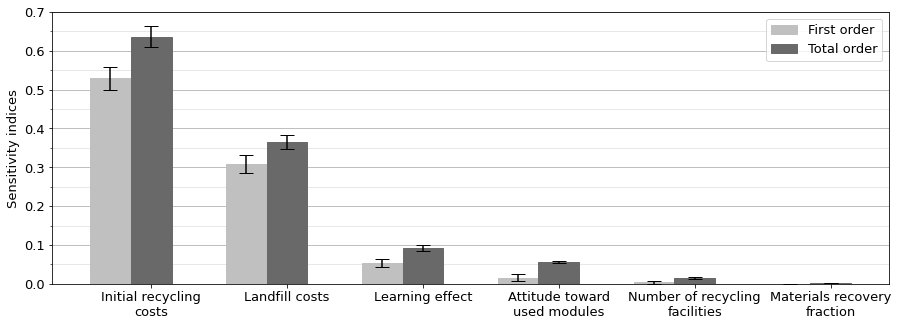

In [66]:
Y_analysis = result_array[:, -1]
Y_analysis = np.array(np.delete(Y_analysis, 0)).astype(np.float)
#print(sobol_abm_5['Y'].to_numpy()) sobol_abm_5['Y'].to_numpy() instead of Y_analysis below
Si = sobol.analyze(problem, Y_analysis, print_to_console=True)
# Negative value are wrong. If so use delta or morris analysis
# or use: So to center the output, is it considered best practice to: 
# (1) subtract the mean, (2) subtract the median, or (3) do (Y - mean) / std as above?
# we may also use Shapley values or something else from the ML output analysis!
# The indices have converged, but some of them are numerically zero. For the negative values, check to see whether 
# their confidence intervals include zero-- if so, you can safely treat them as zero.
# Generally speaking, the most sensitive parameters should have narrow confidence intervals, which are less 
# than 10% of the sensitivity indices (doi: 10.1002/psp4.6)
# Confidence interval is one-sided
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rc('axes', labelsize=13)
barWidth = 0.3
bars1 = list(Si["S1"])
bars2 = list(Si["ST"])
err1 = list(Si["S1_conf"])
err2 = list(Si["ST_conf"])
labels = ['Materials recovery fraction', 'Number of recycling facilities',
                  'Initial recycling costs', 'Landfill costs', 'Attitude toward used modules', 'Learning effect']

df = pd.DataFrame(list(zip(bars1, bars2, err1, err2, labels)), columns=['bars1', 'bars2', 'err1', 'err2', 'labels'])
df = df.sort_values('bars1', ascending=False)
bars1 = df['bars1'].to_list()
bars2 = df['bars2'].to_list()
err1 = df['err1'].to_list()
err2 = df['err2'].to_list()
labels = df['labels'].to_list()

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
fig, ax = plt.subplots(1, 1)
ax.grid(zorder=0)
ax.xaxis.grid(False)
ax.bar(r1, bars1, width = barWidth, color = 'silver', edgecolor = 'silver', yerr=err1, capsize=7, label='First order', 
      zorder=3)
ax.bar(r2, bars2, width = barWidth, color = 'dimgrey', edgecolor = 'dimgrey', yerr=err2, capsize=7, 
        label='Total order', zorder=3)
from textwrap import wrap

labels = [ '\n'.join(wrap(l, 19)) for l in labels ]
plt.xticks([r + barWidth for r in range(len(bars1))], labels)
plt.ylabel('Sensitivity indices')
plt.legend(fontsize=13)
import matplotlib as mpl
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(2))
#ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.grid(b=True, which='minor', color='lightgrey', linewidth=0.5)
ax.set_ylim(0, 0.7)
plt.savefig("SobolIndicesMomentSensitivityAnalysis.png", bbox_inches='tight', figsize=(5.5, 3.5), dpi=500)
SA_results = pd.DataFrame.from_dict(Si, orient='index')
SA_results.columns = ["recovery_fractions", "num_recyclers",
                  "original_recycling_cost", "landfill_cost",
                  "att_distrib_param_reuse", "recycling_learning_shape_factor"]
SA_results = SA_results.T
#print(SA_results.columns.tolist())
#SA_results.drop(['S2', 'S2_conf'], axis=1)
#SA_results = SA_results.astype(float)
SA_results.head()
SA_results.to_csv("SA_results.csv")

Parameter delta delta_conf S1 S1_conf
recovery_fractions 0.070626 0.006560 0.034047 0.005877
num_recyclers 0.047797 0.005101 0.015723 0.004278
original_recycling_cost 0.198723 0.005772 0.294660 0.010067
landfill_cost 0.092021 0.007518 0.072568 0.006979
att_distrib_param_reuse 0.054544 0.005298 0.015349 0.004116
product_lifetime 0.150489 0.006465 0.175342 0.010149
recycling_learning_shape_factor 0.253023 0.006027 0.399428 0.011048
[0.07062574969434211, 0.047797277512128096, 0.1987231464526101, 0.09202129961909261, 0.054543630044399265, 0.1504892148904267, 0.2530226234946062] 0.8672229417076052


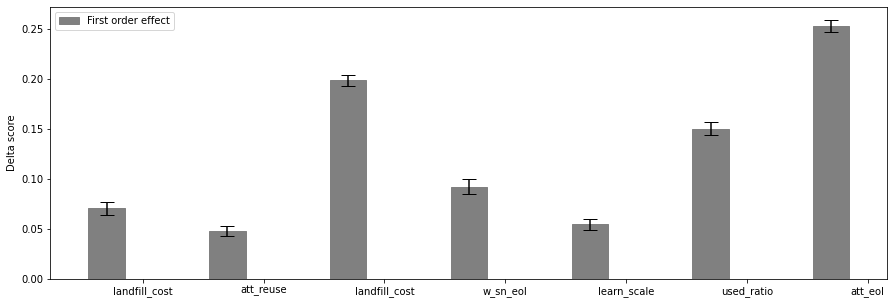

In [35]:
already_analyzed = False
if not already_analyzed:
    Si = delta.analyze(problem, X_pred, Y_analysis, print_to_console=True)
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5
barWidth = 0.3
bars1 = list(Si["delta"])
print(bars1, sum(bars1))
err1 = list(Si["delta_conf"])
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
plt.bar(r1, bars1, width = barWidth, color = 'grey', edgecolor = 'grey', yerr=err1, capsize=7, 
        label='First order effect')
plt.xticks([r + barWidth for r in range(len(bars1))], ['landfill_cost', 'att_reuse', 'landfill_cost',
                  'w_sn_eol', 'learn_scale', 'used_ratio', 'att_eol'])
plt.ylabel('Delta score')
plt.legend()
plt.savefig("DeltaMomentSensitivityAnalysis.png", bbox_inches='tight', figsize=(5.5, 3.5), dpi=500)
with open('DeltaSAresults.csv', 'w') as output:
    writer = csv.writer(output)
    for key, value in Si.items():
        writer.writerow([key, value])

0.2930403337141322
Mean R2 Y1 0.9487355616105498 Standard deviation R2 0.019057367065567363


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


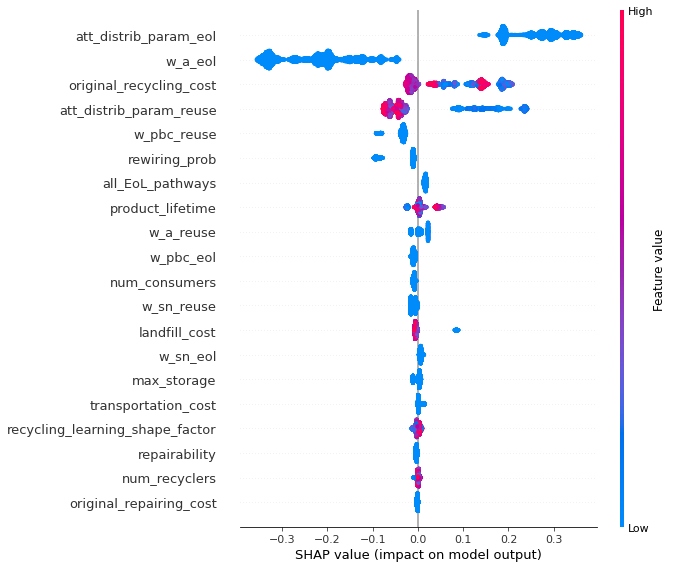

In [14]:
import shap
# With tree-based use: TreeExplainer
# shap_values = shap.KernelExplainer(clf.predict, X_train, link="logit").shap_values(X_pred)
#X_pred2 = np.delete(result_array, -1, axis=1)
#print(X_pred2)
X_pred2 = np.delete(result_array, -1, axis=1)
X_pred2 = np.delete(result_array, 0, axis=1)
X_pred2 = np.delete(X_pred2, (0), axis=0)
X_pred2 = sc.fit_transform(X_pred2)
print(Y_analysis.mean())
rfr = RandomForestRegressor(n_estimators=300, max_depth=8)
print("Mean R2 Y1", cross_val_score(rfr, X, y, cv=10, scoring="r2").mean(), 
      "Standard deviation R2", cross_val_score(rfr, X, y, cv=10, scoring="r2").std())
rfr.fit(X, y)
shap_values = shap.TreeExplainer(rfr).shap_values(X_pred2)
#shap.summary_plot(shap_values, X_pred, plot_type="bar")
f = plt.figure()
shap.summary_plot(shap_values, X_pred2, feature_names = ["all_EoL_pathways", "recovery_fractions", "num_recyclers",
                  "original_recycling_cost", "landfill_cost",
                  "original_repairing_cost", "scndhand_mkt_pric_rate",
                  "max_storage", "att_distrib_param_eol",
                  "att_distrib_param_reuse", "num_consumers",
                  "product_lifetime", "recycling_learning_shape_factor",
                  "rewiring_prob", "w_sn_eol", "w_a_eol", "w_pbc_eol",
                  "w_sn_reuse", "w_a_reuse", "w_pbc_reuse",
                  "transportation_cost", "repairability"])
f.savefig("Shap_values_summary.png", bbox_inches='tight', figsize=(5.5, 3.5), dpi=500)

# Isopleth

In [132]:
result_array = np.empty((0, 4))
count=0
for i in np.linspace(0, 2, 100):
    for j in np.linspace(0, 1, 100):
        Xnew = [[1E-6, 16.0, j, i, 0.223, 0.39]]
        Xnew = sc.transform(Xnew)
        #ynew = rfr.predict(Xnew)
        ynew = model.predict(Xnew)
        result_array = np.append(result_array, [[i*j, i, j, float(ynew)]], axis=0)
        count += 1
        clear_output(wait=True)
        print('loop ', count, ' out of ', len(np.linspace(0, 1, 100))*len(np.linspace(0, 1, 100)))
var_names = np.array(['index', 'Recycling costs', 'Landfill costs', 'Recycling rate'])
result_array =  np.vstack((var_names, result_array))
data_out3 = pd.DataFrame(data=result_array[1:,1:], columns=result_array[0,1:])
data_out3.to_csv("Data_out9.csv")

loop  10000  out of  10000


Normalized data_in5 to 0-max
Normalized data_in5 to 0-1


C:\Users\jwalzber\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:177: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.


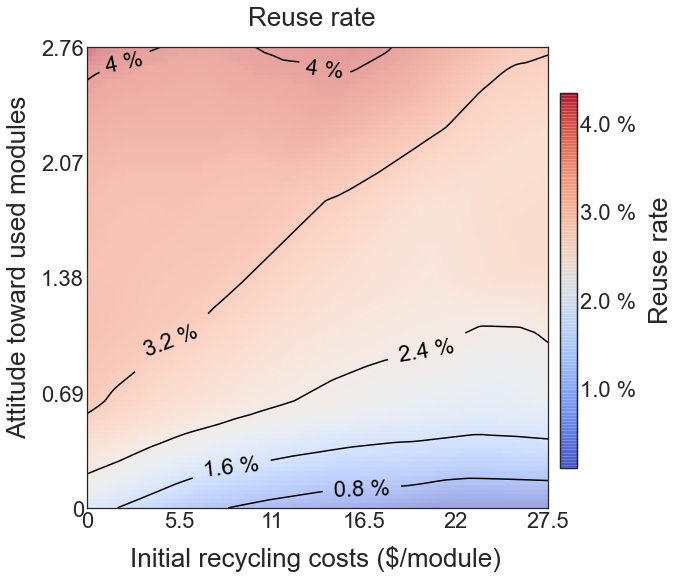

In [149]:
#sns.set(style="whitegrid", font_scale=1.6, color_codes=True)
from pylab import rcParams
import matplotlib.ticker as mtick
import textwrap
#print(data_in)
plt.style.use('seaborn-white')

#def f(x, y):
 #   return np.sin(x) ** 10 + np.cos(10 + y * x) * np.cos(x)

#x = np.linspace(0, 5, 500)
#y = np.linspace(0, 5, 400)

#X, Y = np.meshgrid(x, y)
#Z = f(X, Y)
#.ravel().tolist()
data_in = pd.read_csv("Data_out9.csv")
# NewValue = (((OldValue - OldMin) * (NewMax - NewMin)) / (OldMax - OldMin)) + NewMin
#data_in["Recycling costs"] = (((data_in["Recycling costs"] - data_in["Recycling costs"].min()) * (1 - 0.8)) 
 #                            / (data_in["Recycling costs"].max() - data_in["Recycling costs"].min()) + 0.8)
#data_in["Landfill costs"] = (((data_in["Recycling costs"] - data_in["Recycling costs"].min()) * (28 - 0)) 
 #                            / (data_in["Recycling costs"].max() - data_in["Recycling costs"].min()) + 0)
x = data_in["Recycling costs"].unique()
y = data_in["Landfill costs"].unique()
x = x/2
X, Y = np.meshgrid(x, y)
# normalize data to avoid prediction below 0% or above 100%
if sum(data_in["Recycling rate"] < 0) > 0 or sum(data_in["Recycling rate"] > 1) > 0:
    print('Normalized data_in to 0-max')
    data_in["Recycling rate"] = ((data_in["Recycling rate"] - data_in["Recycling rate"].min()) 
                             / (data_in["Recycling rate"].max() - data_in["Recycling rate"].min()) * 
                             data_in["Recycling rate"].max())
    if sum(data_in["Recycling rate"] > 1) > 0:
        print('Normalized data_in to 0-1')
        data_in["Recycling rate"] = ((data_in["Recycling rate"] - data_in["Recycling rate"].min()) 
                             / (data_in["Recycling rate"].max() - data_in["Recycling rate"].min()))
Z = data_in["Recycling rate"].values * 100 #* 0.8036
Z = Z.reshape((len(x), len(y)))

data_in2 = pd.read_csv("Data_out5.csv")
data_in2["Recycling costs"] = ((data_in2["Recycling costs"] - data_in2["Recycling costs"].min()) 
                             / (data_in2["Recycling costs"].max() - data_in2["Recycling costs"].min()))
data_in2["Landfill costs"] = ((data_in2["Landfill costs"] - data_in2["Landfill costs"].min()) 
                             / (data_in2["Landfill costs"].max() - data_in2["Landfill costs"].min()))
x2 = data_in2["Recycling costs"].unique()
y2 = data_in2["Landfill costs"].unique()
X2, Y2 = np.meshgrid(x2, y2)
# normalize data to avoid prediction below 0% or above 100%
if sum(data_in2["Recycling rate"] < 0) > 0 or sum(data_in2["Recycling rate"] > 1) > 0:
    print('Normalized data_in2 to 0-max')
    data_in2["Recycling rate"] = ((data_in2["Recycling rate"] - data_in2["Recycling rate"].min()) 
                             / (data_in2["Recycling rate"].max() - data_in2["Recycling rate"].min()) * 
                             data_in2["Recycling rate"].max())
    if sum(data_in2["Recycling rate"] > 1) > 0:
        print('Normalized data_in2 to 0-1')
        data_in2["Recycling rate"] = ((data_in2["Recycling rate"] - data_in2["Recycling rate"].min()) 
                             / (data_in2["Recycling rate"].max() - data_in2["Recycling rate"].min()))
Z2 = data_in2["Recycling rate"].values * 100
Z2 = Z2.reshape((len(x2), len(y2)))

data_in3 = pd.read_csv("Data_out5.csv")
data_in3["Recycling costs"] = ((data_in3["Recycling costs"] - data_in3["Recycling costs"].min()) 
                             / (data_in3["Recycling costs"].max() - data_in3["Recycling costs"].min()))
data_in3["Landfill costs"] = ((data_in3["Landfill costs"] - data_in3["Landfill costs"].min()) 
                             / (data_in3["Landfill costs"].max() - data_in3["Landfill costs"].min()))
x3 = data_in3["Recycling costs"].unique()
y3 = data_in3["Landfill costs"].unique()
X3, Y3 = np.meshgrid(x3, y3)
# normalize data to avoid prediction below 0% or above 100%
if sum(data_in3["Recycling rate"] < 0) > 0 or sum(data_in3["Recycling rate"] > 1) > 0:
    print('Normalized data_in3 to 0-max')
    data_in3["Recycling rate"] = ((data_in3["Recycling rate"] - data_in3["Recycling rate"].min()) 
                             / (data_in3["Recycling rate"].max() - data_in3["Recycling rate"].min()) * 
                             data_in3["Recycling rate"].max())
    if sum(data_in3["Recycling rate"] > 1) > 0:
        print('Normalized data_in3 to 0-1')
        data_in3["Recycling rate"] = ((data_in3["Recycling rate"] - data_in3["Recycling rate"].min()) 
                             / (data_in3["Recycling rate"].max() - data_in3["Recycling rate"].min()))
Z3 = data_in3["Recycling rate"].values * 100
Z3 = Z3.reshape((len(x3), len(y3)))

data_in4 = pd.read_csv("Data_out6.csv")
data_in4["Recycling costs"] = ((data_in4["Recycling costs"] - data_in4["Recycling costs"].min()) 
                             / (data_in4["Recycling costs"].max() - data_in4["Recycling costs"].min()))
data_in4["Landfill costs"] = ((data_in4["Landfill costs"] - data_in4["Landfill costs"].min()) 
                             / (data_in4["Landfill costs"].max() - data_in4["Landfill costs"].min()))
x4 = data_in4["Recycling costs"].unique()
y4 = data_in4["Landfill costs"].unique()
X4, Y4 = np.meshgrid(x4, y4)
# normalize data to avoid prediction below 0% or above 100%
if sum(data_in4["Recycling rate"] < 0) > 0 or sum(data_in4["Recycling rate"] > 1) > 0:
    print('Normalized data_in4 to 0-max')
    data_in4["Recycling rate"] = ((data_in4["Recycling rate"] - data_in4["Recycling rate"].min()) 
                             / (data_in4["Recycling rate"].max() - data_in4["Recycling rate"].min()) * 
                             data_in4["Recycling rate"].max())
    if sum(data_in4["Recycling rate"] > 1) > 0:
        print('Normalized data_in4 to 0-1')
        data_in4["Recycling rate"] = ((data_in4["Recycling rate"] - data_in4["Recycling rate"].min()) 
                             / (data_in4["Recycling rate"].max() - data_in4["Recycling rate"].min()))
Z4 = data_in4["Recycling rate"].values * 100
Z4 = Z4.reshape((len(x4), len(y4)))

data_in5 = pd.read_csv("Data_out7.csv")
x5 = data_in5["Recycling costs"].unique()
y5 = data_in5["Landfill costs"].unique()
X5, Y5 = np.meshgrid(x5, y5)
# normalize data to avoid prediction below 0% or above 100%
if sum(data_in5["Recycling rate"] < 0) > 0 or sum(data_in5["Recycling rate"] > 1) > 0:
    print('Normalized data_in5 to 0-max')
    data_in5["Recycling rate"] = ((data_in5["Recycling rate"] - data_in5["Recycling rate"].min()) 
                             / (data_in5["Recycling rate"].max() - data_in5["Recycling rate"].min()) * 
                             data_in5["Recycling rate"].max())
    if sum(data_in5["Recycling rate"] > 1) > 0:
        print('Normalized data_in5 to 0-1')
        data_in5["Recycling rate"] = ((data_in5["Recycling rate"] - data_in5["Recycling rate"].min()) 
                             / (data_in5["Recycling rate"].max() - data_in5["Recycling rate"].min()))
Z5 = data_in5["Recycling rate"].values * 100
Z5 = Z5.reshape((len(x5), len(y5)))

# HERE: normalize z from 0 to 100

class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.0f' % self.__float__()
        else:
            return '%.1f' % self.__float__()

#figure, axes = plt.subplots(nrows=3, ncols=3)
fig = plt.figure(figsize=(8, 4))
num=0
for i in range(1):
    num+=1
 
    # Find the right spot on the plot
    plt.subplot(1,1, num)
 
    if plt.rcParams["text.usetex"]:
        fmt = r'%r \%%'
    else:
        fmt = '%r %%'

    # Plot the lineplot
    if num == 1:
        CS = plt.contour(X, Y, Z, 5, colors='black')
        CS.levels = [nf(val) for val in CS.levels]
        im = plt.imshow(Z, extent=[0, 1, 0, 1], origin='lower',
               cmap='coolwarm', alpha=0.5)
        #plt.clabel(CS, CS.levels, fmt='%1.0f', inline=True, fontsize=22)
        plt.clabel(CS, CS.levels, fmt=fmt, inline=True, fontsize=22)
    elif num == 2:
        CS2 = plt.contour(X2, Y2, Z2, 5, colors='black')
        CS2.levels = [nf(val) for val in CS2.levels]
        im = plt.imshow(Z2, extent=[0, 1, 0, 1], origin='lower',
               cmap='coolwarm', alpha=0.5, vmin=0, vmax=100)
        plt.clabel(CS2, CS2.levels, fmt=fmt, inline=True, fontsize=9)
    elif num == 3:
        CS3 = plt.contour(X3, Y3, Z3, 5, colors='black')
        CS3.levels = [nf(val) for val in CS3.levels]
        im = plt.imshow(Z3, extent=[0, 1, 0, 1], origin='lower',
               cmap='coolwarm', alpha=0.5, vmin=0, vmax=100)
        plt.clabel(CS3, CS3.levels, fmt=fmt, inline=True, fontsize=9)
    elif num == 4:
        CS4 = plt.contour(X4, Y4, Z4, 5, colors='black')
        CS4.levels = [nf(val) for val in CS4.levels]
        im = plt.imshow(Z4, extent=[0, 1, 0, 1], origin='lower',
               cmap='coolwarm', alpha=0.5, vmin=0, vmax=100)
        plt.clabel(CS4, CS4.levels, fmt=fmt, inline=True, fontsize=9)
    else:
        CS5 = plt.contour(X5, Y5, Z5, 5, colors='black')
        CS5.levels = [nf(val) for val in CS5.levels]
        im = plt.imshow(Z5, extent=[0, 1, 0, 1], origin='lower',
               cmap='coolwarm', alpha=0.5, vmin=0, vmax=100)
        plt.clabel(CS5, CS5.levels, fmt=fmt, inline=True, fontsize=9)

    plt.axis(aspect='image')
 
    # Same limits for everybody!
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1], [0, 5.5, 11, 16.5, 22, 27.5])
    plt.yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.69, 1.38, 2.07, 2.76])
    #plt.yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1])
    #plt.yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.15, 0.3, 0.45, 0.6])
    #plt.yticks([0, 0.25, 0.5, 0.75, 1], [1, 24, 48, 72, 96])
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
 
    # Not ticks everywhere
    #if num in range(3):
     #   plt.tick_params(axis='x', labelbottom=False)
    if num not in [1,3]:
        plt.tick_params(axis='y', labelleft=False)
    #if num in [3,6,9]:
     #   plt.colorbar()
 
    # Add title
    from textwrap import wrap
    title_list = [" ", "Landfill cost (x1) - improved warranties (x2)", 
                  "Recycling cost (x1) - product lifetime (x2)", "Recycling cost (x1) - number facilities (x2)", 
                 "Recycling cost (x1) - learning effect (x2)", "Recycling cost (x1) - learning effect (x2)"]
    title_list = [ '\n'.join(wrap(l, 50)) for l in title_list ]
    plt.title(title_list[i], loc='center', fontsize=16, fontweight=0.2)
    # use adjust to get the figure correct margins
plt.subplots_adjust(left=0.,
                    bottom=0., 
                    right=0.8, 
                    top=1.6, 
                    wspace=0.1, 
                    hspace=0.2)
cbar_ax = fig.add_axes([0.82, 0.14, 0.03, 1.3])
fig.colorbar(im, cax=cbar_ax)
fig.colorbar(im, cax=cbar_ax, format="%r %%")
cbar_ax.tick_params(labelsize=22)
plt.text(22, 1.8, 'Reuse rate', rotation='vertical', 
         fontsize=26)
#plt.text(0, 0, 'Modules in CE pathways', ha='center', va='center', rotation='vertical', 
 #        fontsize=14)
# Axis title
plt.text(-105, -1, 'Initial recycling costs ($/module)', fontsize=26)
#plt.text(0.2, 1.05, 'Material circularity rate', fontsize=26)
plt.text(-76, 5.1, 'Reuse rate', fontsize=26)
plt.text(-135, 0.5, 'Attitude toward used modules', rotation='vertical', 
         fontsize=26)
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.savefig("figure10.2.png", bbox_inches='tight', figsize=(3, 2), dpi=500)

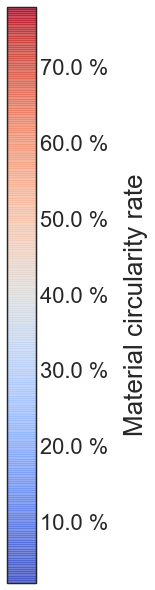

In [154]:
fig = plt.figure(figsize=(8, 4))
cbar_ax = fig.add_axes([1, 0.14, 0.05, 2])
fig.colorbar(im, cax=cbar_ax)
fig.colorbar(im, cax=cbar_ax, format="%r %%")
cbar_ax.tick_params(labelsize=22)
plt.text(310, 22, 'Material circularity rate', rotation='vertical', 
         fontsize=26)
plt.savefig("figure10.2.png", bbox_inches='tight', figsize=(3, 2), dpi=500)